In [17]:
import pandas as pd
import re
import numpy as np

from sklearn.cross_validation import train_test_split

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_curve, auc, f1_score

from gensim.models.word2vec import Word2Vec
from functools import partial

import matplotlib.pyplot as plt

Загружаем данные

In [18]:
df = pd.read_csv('reviews_clear.csv', sep='^')
df.rename(index=str, columns={"rt" : "Rate", "review" : "Review"}, inplace=True)
df.head()

,Rate,Review
0,plus,Everything was great. I was really happy stayi...
1,minus,I'm interested to see what the construction in...
2,plus,Location was good. Really good air conditioning.
3,minus,Room wasn’t clean. I found hair in the bed and...
4,plus,Room was beautifully decorated and over all ho...


Обрабатываем текст: 
* удаляем дубликаты, 
* оставляем только цифры и буквы в тексте
* приводим буквы к нижнему регистру


In [34]:
df = df.dropna().drop_duplicates()

df.Review = df.Review.apply(partial(re.sub, '[^a-zA-Z1-9 ]', ' '))
df.Review = df.Review.apply(str.lower)

Переводим данные в более удобном виде в numpy массив

In [20]:
def transform_data(df):
    # use 1 for positive sentiment, 0 for negative
    pos_size = df.Rate.value_counts()['plus']
    neg_size = df.Rate.value_counts()['minus']
    y = np.concatenate((np.ones(pos_size), np.zeros(neg_size))).astype(np.int)
    
    # decode dataframe to nupy
    pos_idx = df.Rate == 'plus'
    neg_idx = df.Rate == 'minus'
    pos_rev = np.array(df.Review[pos_idx])
    neg_rev = np.array(df.Review[neg_idx])
    X = np.concatenate((pos_rev, neg_rev))
    
    # Each element decode to list of words
    for i, x in enumerate(X):
        X[i] = filter(bool, x.replace('  ', ' ').split(' '))
    
    return y, X

Разделяем на тренирововчную и тестовую выборку

In [27]:
y, X = transform_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

Преобразовывание отзыва в вектор с помощью усреднения векторов слов в тексте, которые присутвуют в модели
    

In [6]:
def buildWordVector(text, size, rev_w2v):
    
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in text:
        try:
            vec +=rev_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
        
    return vec

Тренировка модели преобразования текста на загруженном корпусе

In [7]:
def encode_data(X_train, X_test, n_dim=300, epoch_count=100):

    example_count = X_train.size
    
    #Initialize model and build vocabluary
    rev_w2v = Word2Vec(size=n_dim, min_count=5)
    rev_w2v.build_vocab(X_train)
    
    # Train the model over train_reviews
    rev_w2v.train(X_train, total_examples=example_count, epochs=epoch_count)
    train_vecs = np.concatenate([buildWordVector(item, n_dim, rev_w2v) for item in X_train])
    
    # Train the model over test_reviews
    rev_w2v.train(X_test, total_examples=X_test.size, epochs=epoch_count)
    test_vecs = np.concatenate([buildWordVector(z, n_dim, rev_w2v) for z in X_test])
    
    return train_vecs, test_vecs

Функция построения графика

In [33]:
def make_plot(y_test, preds):
    
    plt.figure(figsize=(9, 7))
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC score= %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    print "F1-score: %0.2f, AUC score = %0.2f" % (f1_score(y_test, prediction.round()) ,roc_auc)    
    
    plt.show()

Примениен на нескольких моделях:
* Случайный лес
* Метод опрпных векторов
* Логистическая регрессия

In [32]:
# RandomForest ROC - 0.91
classifier = RandomForestClassifier(n_estimators=200, min_samples_split=30,
                                   criterion='entropy', max_depth=50)

# SVG ROC - 0.89
# classifier = LogisticRegression(max_iter=1e4, C=0.1)

# SVM ROC - 0.9
# classifier = SVC(C=1.0, kernel='rbf', max_iter=1e4, probability=True)

scaler = StandardScaler(with_mean=True, with_std=False)

В Pipeline нормализуем данные и применяем модель

In [31]:
model = Pipeline(
    [
        ('scaler', scaler),
        ('main', classifier)
    ]
)

Тренировка модели

In [12]:
train_vecs, test_vecs = encode_data(X_train, X_test, n_dim=300, epoch_count=100)
model = model.fit(train_vecs, y_train)

Предсказание данных

In [22]:
probability = model.predict_proba(test_vecs)
prediction = probability[:,1]

Отрисовка результатов оценки качества модели

F1-score: 0.79, AUC score = 0.91


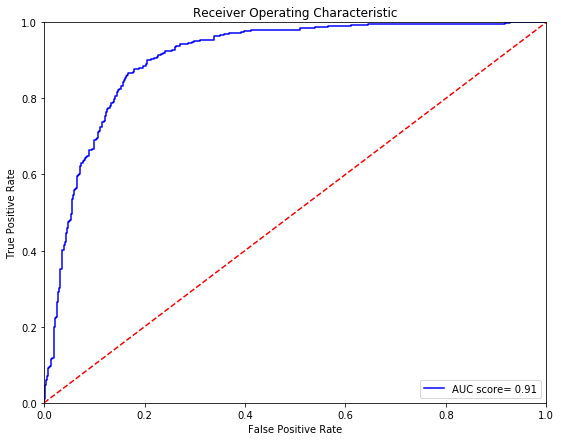

In [23]:
make_plot(y_test, prediction)